# 9장. 시퀀스와 시계열 데이터 이해하기

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch09/09-time-series.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch09/09-time-series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 시계열 예측 기법

### 기준 성능을 위한 단순한 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """일정 간격마다 동일 패턴 반복"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

# 시계열 만들기
series = baseline + trend(time, slope) \
                  + seasonality(time, period=365, amplitude=amplitude)

# 잡음 추가
series += noise(time, noise_level, seed=42)

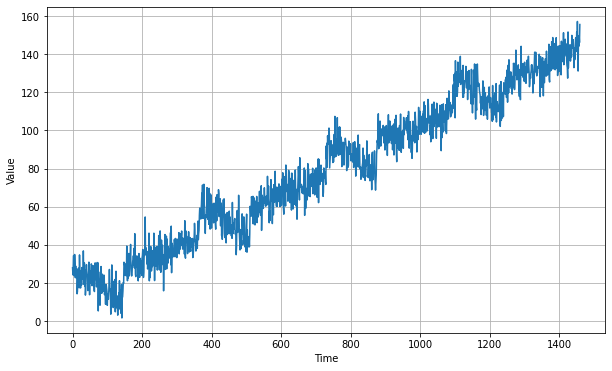

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

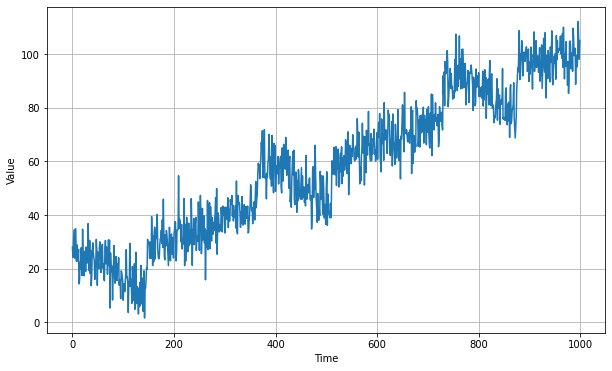

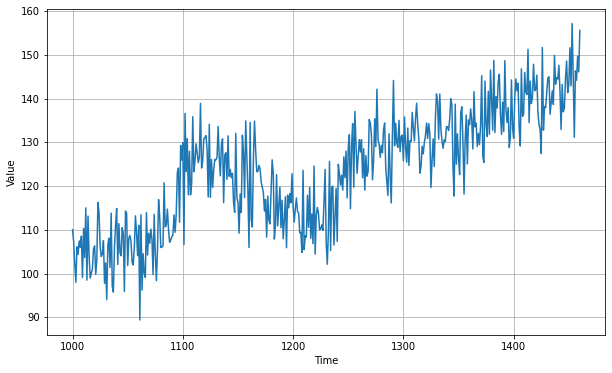

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [5]:
naive_forecast = series[split_time - 1:-1]

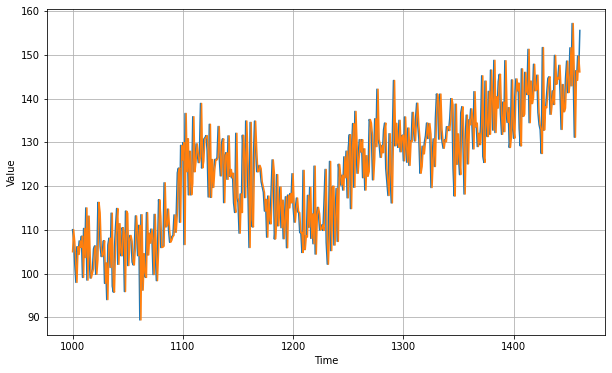

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

### 예측 정확도 측정

In [7]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

76.47491
6.899298


### 이동 평균으로 예측하기

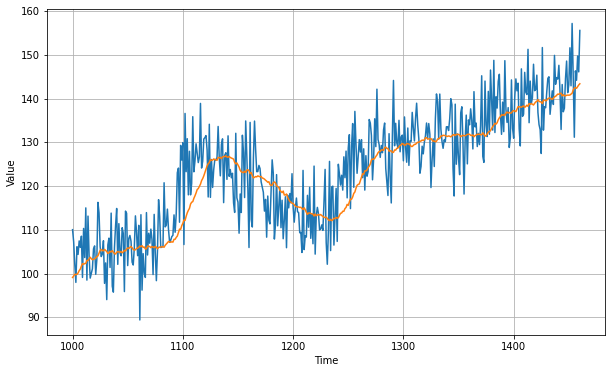

In [8]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
       If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [9]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

49.044434
5.5328355


### 개선된 이동 평균 방법

In [10]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

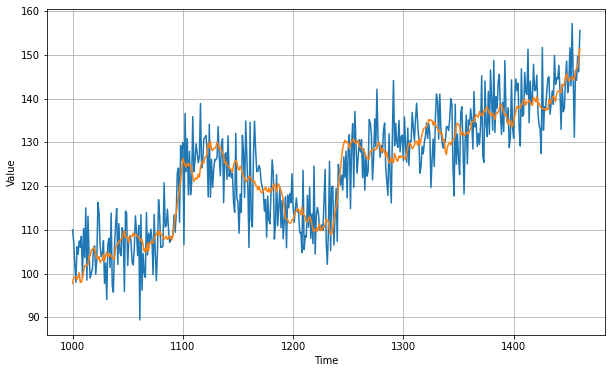

In [11]:
diff_moving_avg = \
    moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

diff_moving_avg_plus_smooth_past = \
    moving_average_forecast(series[split_time - 370:-360], 10) + \
    diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [12]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

40.902336
5.1360006
